## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

** Imports and Get Calibration Parameters Function **

In [1]:
import matplotlib.image as  mpimg
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
import glob
import cv2
%matplotlib inline

def get_cal_param(path, size):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    obj_points = [] # 3d points in real world space
    img_points = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(path)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the 9x6 chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, size, None)

        # If found, add object points, image points
        if ret == True:
            obj_points.append(objp)
            img_points.append(corners)
            
    return obj_points, img_points

** Helper Functions **

In [2]:
# display sub plot of two images with titles
def sub_plt(img1, img2, title1, title2, cmap1=None, cmap2=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title(title1, fontsize=16)
    ax1.imshow(img1, cmap=cmap1)

    ax2.set_title(title2, fontsize=16)
    ax2.imshow(img2, cmap=cmap2)

** Calibrate Camera and Undistort Images **

In [3]:
# performs the camera calibration, image distortion correction 
# and returns the undistorted image
def cal_undistort(img, obj_points, img_points):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        obj_points, img_points, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [4]:
obj_points, img_points = get_cal_param('./camera_cal/calibration*.jpg', (9,6))

images = ['./camera_cal/calibration1.jpg']

images += glob.glob('./test_images/test*.jpg')

for fname in images:
    # Read in an image
    img = mpimg.imread(fname)

    undistorted = cal_undistort(img, obj_points, img_points)
    
    sub_plt(img, undistorted, 'Original Image', 'Undistorted Image')

NameError: name 'imgpoints' is not defined

## Lane line detection on a straight road

** Undistort Test Image **

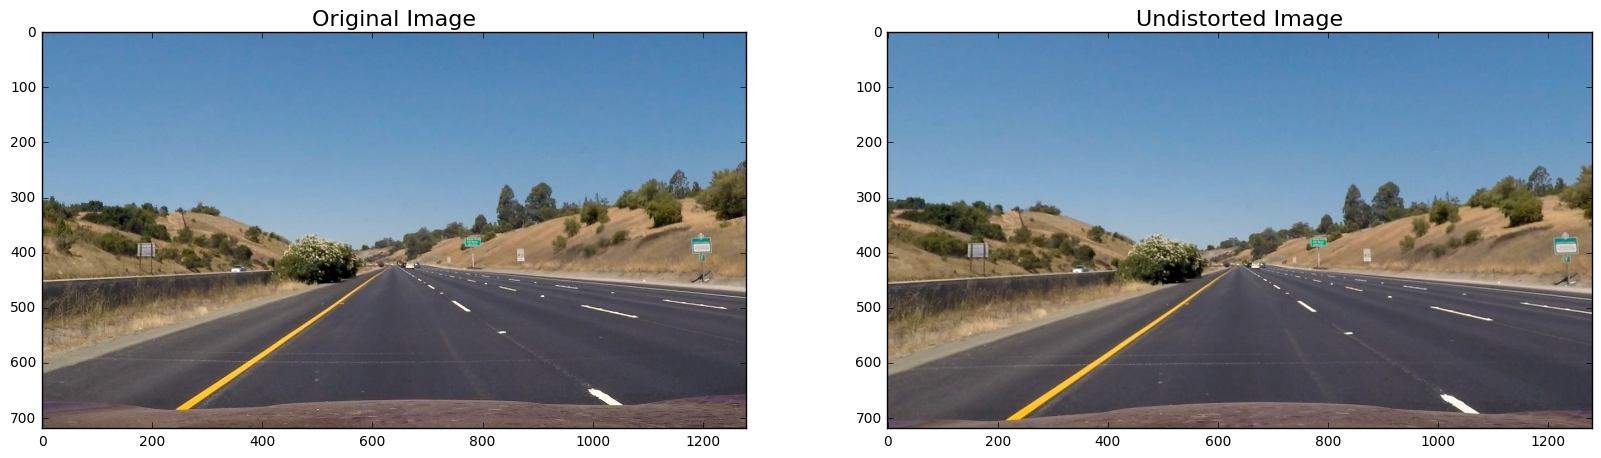

In [188]:
# Get image of straight road
image = mpimg.imread('./test_images/straight_lines1.jpg')

# Calibrate camera and undistor image
undistorted = cal_undistort(image, obj_points, img_points)

# display original and undistorted images
sub_plt(image, undistorted, 'Original Image', 'Undistorted Image')

** Set and Display Source Image Points **

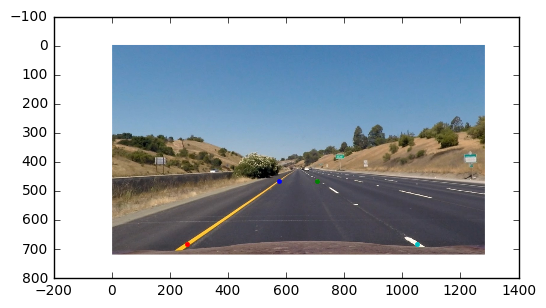

In [189]:
# Source image points
plt.imshow(undistorted)

# Image dimentions array
img_size = np.shape(undistorted)

# Order: top left, bottom left, bottom right, top right
src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])

# format is in x, y, dot
plt.plot(src[0][0], src[0][1], '.') 
plt.plot(src[1][0], src[1][1], '.') 
plt.plot(src[2][0], src[2][1], '.') 
plt.plot(src[3][0], src[3][1], '.') 

** Perspective Transform Function **

In [190]:
def warp(img, src, dst):
    
    # Define calibration box in source (original) and destination (desired or waped) coordinates
    img_size = (img.shape[1], img.shape[0])
    
    # Four source coordinates
    src = np.float32(src)
    
    # Four desired coordinates
    dst = np.float32(dst)
    
    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Compute the inverse also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, Minv

** Set and Visualize Destination Points for Perspective Tranform **

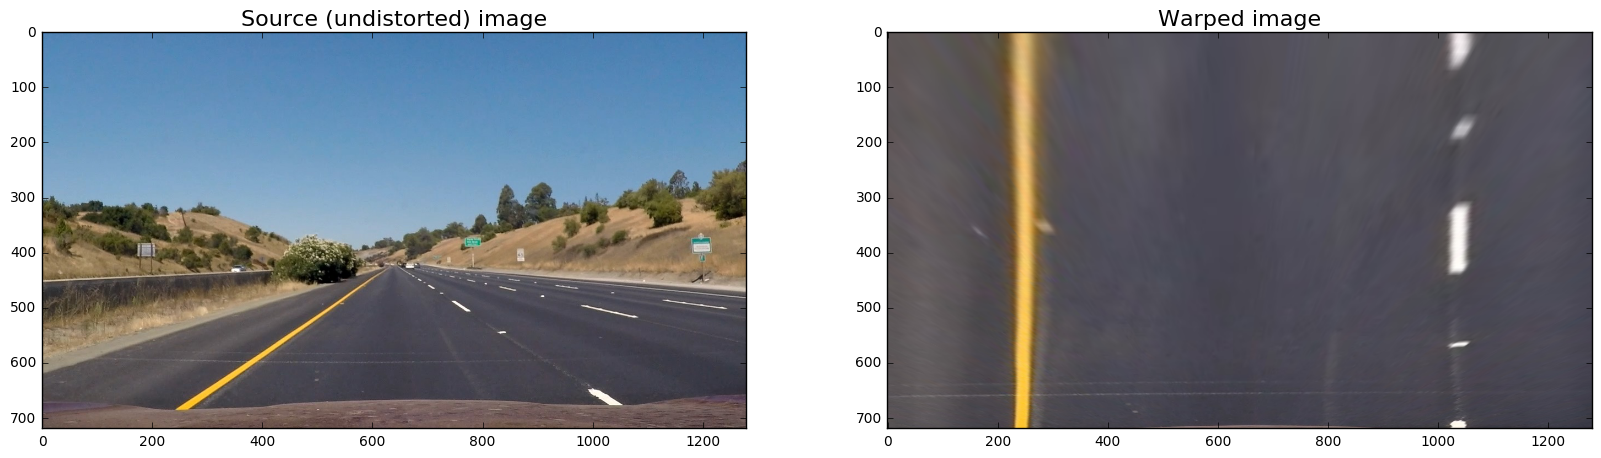

In [191]:
# Order: top left, bottom left, bottom right, top right
dst = np.float32([[240, 0],
                  [img_size[1] - 240, 0],
                  [240, img_size[0]],
                  [img_size[1] - 240, img_size[0]]])

# Get perspective transform
warped, Minv  = warp(undistorted, src, dst)

# Visualize undistorted image and warped image
sub_plt(image, warped, 'Source (undistorted) image', 'Warped image')

** Pipeline Function **

In [192]:
def pipeline(img):
    # Add Guassian blur to remove noise
    img = cv2.GaussianBlur(img, (5, 5), 0)
    
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    # Add Guassian blur to remove the left over noise
    combined_binary = cv2.GaussianBlur(combined_binary, (5, 5), 0)
    
    return combined_binary

** Visualize Pipeline **

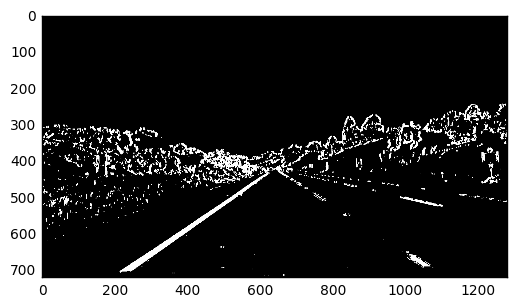

In [193]:
# Get the color and combined binary image from the undistorted image
combined_binary = pipeline(undistorted)

plt.imshow(combined_binary, cmap='gray')

** Visualize warped pipeline **

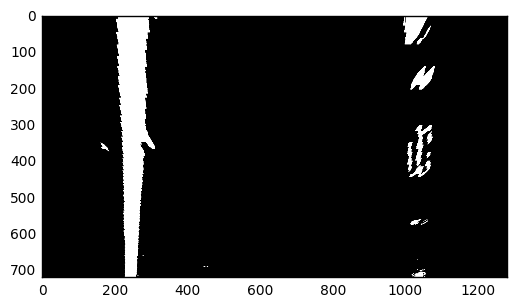

In [194]:
# Warp the combined binary image 
binary_warped, _ = warp(combined_binary, src, dst)

# Display image
plt.imshow(binary_warped, cmap='gray')

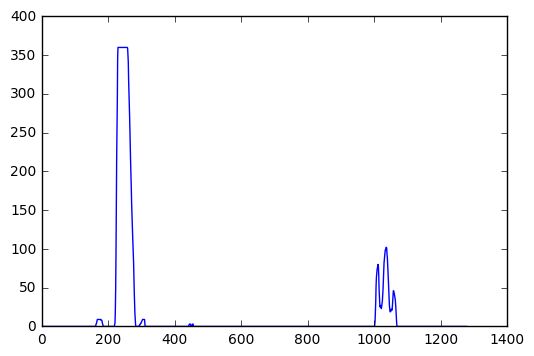

In [195]:
# Plot peaks (lanes) in a Histogram
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

** Implement Sliding Windows and Fit a Polynomial **

In [196]:
def sliding_windows(binary_warped, plt=False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows.
    nwindows = 10
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 90
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if plt:
        return nonzerox, nonzeroy, left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty, left_fit, right_fit
    else:
        return left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty, left_fit, right_fit

** Visualize Sliding Windows and Fit a Polynomial **

(720, 0)

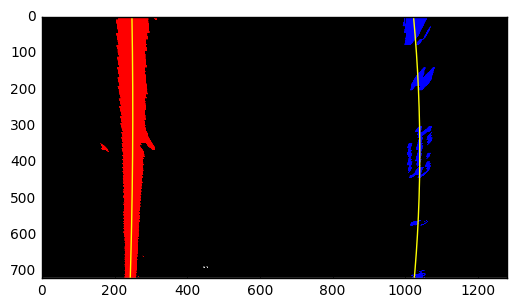

In [197]:
# Get parameters from sliding windows 
nonzerox, nonzeroy, left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty, left_fit, right_fit = sliding_windows(binary_warped, True)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

** Identify Lane-Line Pixels and Fit Their Positions With a Polynomial on a Rolling Average **

In [198]:
def poly_fit_average(binary_warped, left_fit_avg, right_fit_avg):
    # Identify the x and y positions of all nonzero pixels in the imagenonzero = binary_warped.nonzero()
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the width of the windows +/- margin
    margin = 90
    
    # Identify the nonzero pixels in x and y within the window and based on the left and right lane aberage
    left_lane_inds = ((nonzerox > (left_fit_avg[0]*(nonzeroy**2) + left_fit_avg[1]*nonzeroy + left_fit_avg[2] - margin)) & 
                      (nonzerox < (left_fit_avg[0]*(nonzeroy**2) + left_fit_avg[1]*nonzeroy + left_fit_avg[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_avg[0]*(nonzeroy**2) + right_fit_avg[1]*nonzeroy + right_fit_avg[2] - margin)) & 
                       (nonzerox < (right_fit_avg[0]*(nonzeroy**2) + right_fit_avg[1]*nonzeroy + right_fit_avg[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
        right_fit_new = np.polyfit(righty, rightx, 2)
    else:
        # Fall back to sliding windows
        left_fit_new, right_fit_new = sliding_windows(binary_warped)
        
    return left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty, left_fit_new, right_fit_new

** Measure lane Curvature and Offset **

In [199]:
def measure_curvature(ploty, undistorted, left_fitx, right_fitx, left_fit, right_fit, leftx, lefty, rightx, righty):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Calculate offset from the center of the lane
    mid_point = np.int(undistorted.shape[1]/2)
    lane_middle = (right_fitx[-1] - left_fitx[-1]) / 2.0 + left_fitx[-1]
    offset = (mid_point - lane_middle) * xm_per_pix
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature in meters
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
 
    return left_curverad, right_curverad, offset

** Search For Lane-Line Pixels **

In [200]:
# This function is only used for illustrating the search window area
def line_search(binary_warped, left_fit, right_fit):
    # We now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 90
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return margin, ploty, leftx, rightx, left_fitx, right_fitx

** Shade Green the Area Where We Searched for the Line **

(720, 0)

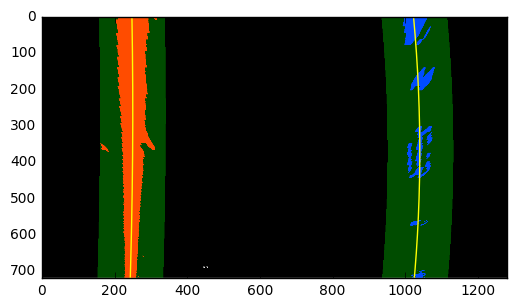

In [201]:
# Get parameters from line search
margin, ploty, leftx, rightx, left_fitx, right_fitx = line_search(binary_warped, left_fit, right_fit)

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

** Draw Measurements Back down onto the Road **

In [202]:
def draw_lines(image, binary_warped, ploty, Minv, left_fitx, right_fitx, undistorted, left_curverad, right_curverad, offset):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

    # Add radius and offset calculations on to the video
    cv2.putText(result,"Offset from the center of the lane: " + "{:0.2f}".format(offset) + 'm', org=(50,50),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(250,250,250), lineType = cv2.LINE_AA, thickness=2)
    cv2.putText(result,"Left Lane Radius: " + "{:0.2f}".format(left_curverad/1000) + 'km', org=(50,100), 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(250,250,250), lineType = cv2.LINE_AA, thickness=2)
    cv2.putText(result,"Right Lane Radius: " + "{:0.2f}".format(right_curverad/1000) + 'km', org=(50,150), 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(250,250,250), lineType = cv2.LINE_AA, thickness=2)
    
    return result

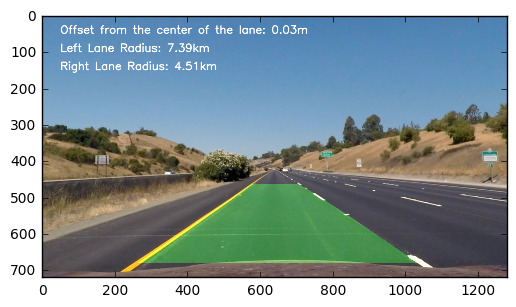

In [203]:
left_curverad, right_curverad, offset = measure_curvature(ploty, undistorted, left_fitx, right_fitx, 
                                                          left_fit, right_fit, leftx, lefty, rightx, righty)

result = draw_lines(image, binary_warped, ploty, Minv, left_fitx, right_fitx, undistorted, left_curverad,
                    right_curverad, offset)

plt.imshow(result)

## Test on Videos

In [2]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

** Puting Eveything Together **

In [161]:
def wraper(frames): 
    myLeftFitBin = deque(maxlen=frames)
    myRightFitBin = deque(maxlen=frames)
    weights = np.arange(1, frames + 1)/frames
    
    def process_image(image):
        """ NOTE: The output you return should be a color image (3 channel) for processing video below """
    
        # Set local variable to the global variables
        left_fit_bin = myLeftFitBin
        right_fit_bin = myRightFitBin
        
        # Calibrate camera and undistort the image
        undistorted = cal_undistort(image, obj_points, img_points)
    
        # Combined S channel and gradient thresholds on undistorted image 
        combined_binary = pipeline(undistorted)
    
        # Warped combined binary image only showing the lane
        binary_warped, Minv = warp(combined_binary, src, dst)
    
        # Only use sliding windows for the first frame
        if (len(left_fit_bin) == 0 and len(right_fit_bin) == 0):
            # Find lanes by using sliding windows, followed by fitting a polynomial
            left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty, left_fit, right_fit = sliding_windows(binary_warped)
            
        else:
            # Fit a polynomial based on the rolling average of the last n number of frames
            left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty, left_fit, right_fit = poly_fit_average(binary_warped, 
                                                   np.average(left_fit_bin, 0, weights[-len(left_fit_bin):]), 
                                                   np.average(right_fit_bin, 0, weights[-len(right_fit_bin):]))
        
        # Append new frame left and right fit
        # deque is a Last in First out, so no need to reset or edit
        left_fit_bin = left_fit_bin.append(left_fit)
        right_fit_bin = right_fit_bin.append(right_fit)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Measure lane curvature (estimate)
        left_curverad, right_curverad, offset = measure_curvature(ploty, undistorted, left_fitx, right_fitx, left_fit, 
                                                                  right_fit, leftx, lefty, rightx, righty)
    
        # Draw detected lane
        result = draw_lines(image, binary_warped, ploty, Minv, left_fitx, right_fitx, 
                            undistorted, left_curverad, right_curverad, offset)
        
        return result
    
    return process_image

** Get Input Video and Write Modified Output Video **

In [162]:
# Initialize previous frame
left_fit_prev, right_fit_prev = None, None

# Video ouput with lane line detection
project_output = 'project_output.mp4'

# Input test video 
clip1 = VideoFileClip("./project_video.mp4")

white_clip = clip1.fl_image(wraper(15)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [14:49<00:00,  1.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 33min 23s, sys: 1min 19s, total: 34min 43s
Wall time: 14min 50s


** Display Output Video **

In [3]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



NameError: name 'project_output' is not defined